First anlysis on all data, with normal classifier

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from classifier import MLPBinary
import utils

L = 10
T_CRIT = 2.2691853

In [ ]:
# resizing of the data created with monte carlo

lt, ut, t_step = 1.0, 3.2, 0.003

#for L in [10, 15, 20]:
 #   utils.resize_data(L, lt, ut)
    
utils.resize_data_test(10)

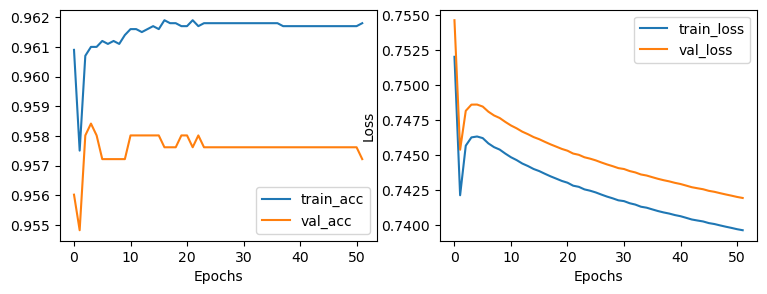

In [2]:
# NORMAL CLASSIFIER, TRAINED ON ALL DATA
# trained from T=1 to 10
# accuracy migliorata con i dati a 95
clf = utils.train_classifier(10, 'all', MLPBinary(dim_hidden=100, tolerance=1e-4, activation='relu', lr=0.01, batch_size=200, momentum=0.9, solver='sgd', alpha=0.1, power_t=0.5, n_epochs_no_update=5))

In [ ]:
b = clf.weights2.flatten()
b @ b.T

In [ ]:
data_test.shape

In [ ]:
# accuracy on test data, close and far from T_C 
# loading data for testing
data_test = np.load(f"./data/{L}_test.npy").reshape(-1, L*L)
temp_test = np.load(f"./data/{L}_test_temp.npy").reshape(-1,)

t_test = (temp_test > T_CRIT).astype(int)

min_bound = 2.2
max_bound = 2.3

mask = (temp_test > max_bound) | (temp_test < min_bound)   

print(f"All Data : {clf.score(data_test, t_test)}")
print(f"Data with T < {min_bound} or T > {max_bound} : {clf.score(data_test[mask], t_test[mask])}")
print(f"Data with {min_bound} < T < {max_bound}: {clf.score(data_test[~mask], t_test[~mask])}")

# ACCURACY AS FUNCTION OF TEMPERATURE

data_test = np.load(f"./data/{L}_test.npy").reshape(10, 24, L*L)
temp_test = np.load(f"./data/{L}_test_temp.npy").reshape(10, 24)

index = np.argsort(temp_test, axis=1)
temp_test = np.sort(temp_test, axis=1)
index_expanded = index[..., np.newaxis]
data_test = np.take_along_axis(data_test, index_expanded, axis=1)

data_per_temperature = np.array([data_test[:, i, :] for i in range(24)])
temp_test = np.array([temp_test[:, i] for i in range(24)])
t_test = (temp_test > T_CRIT).astype(int).reshape(24,10)

acc  = [clf.score(data_per_temperature[i, :, :], t_test[i, :]) for i in range(24)]
mean_M = np.mean(abs(np.mean(data_per_temperature[:,:, :], axis=2)), axis=1)
err_M = np.std(abs(np.mean(data_per_temperature[:,:, :], axis=2)), axis = 1, ddof=1) / np.sqrt(10)
temp = np.arange(1, 3.4, 0.1)
plt.figure(figsize=(4,5))
plt.scatter(temp, acc)
plt.errorbar(temp, mean_M, err_M, color= 'r')
plt.legend(['acc', 'mean_M'])
plt.show()
plt

## training with different ratio of M>0 data in respect to M<0

In [3]:
# questo per il training
data = np.load(f"data/{L}_test_tanti.npy").reshape(-1, 100)
temp = np.load(f"data/{L}_temp_tanti.npy").reshape(-1,)
n = data.shape[0]
# target value
t = (temp > T_CRIT).astype(int)

mask = ((temp < T_CRIT) & (np.sum(data, axis=1) > 0)) # mask for positive M and t < T_crit
data_M_pos = data[mask]
t_M_pos = t[mask]

mask = ((temp < T_CRIT) & (np.sum(data, axis=1) < 0)) # mask for negative M and t < T_crit
data_M_neg = data[mask]
t_M_neg = t[mask]

data_M_null = data[temp > T_CRIT]
t_M_null = t[temp > T_CRIT]

# dati di test separati per magnetizzazione | devo anche prendere le temperature ordinate correttamente -> che so la label
# al momento solo su un set di temperature
data_test = np.load(f"./data/{L}_test.npy").reshape(10, 24, L*L)
temp_test = np.load(f"./data/{L}_test_temp.npy").reshape(10, 24)

index = np.argsort(temp_test, axis=1)
temp_test = np.sort(temp_test, axis=1)
index_expanded = index[..., np.newaxis]
data_test = np.take_along_axis(data_test, index_expanded, axis=1)

slices = np.array([data_test[:, i, :] for i in range(24)])
temp_test = np.array([temp_test[:, i] for i in range(24)])

mask = (temp_test > T_CRIT).astype(int)
data_test_M_null = slices[13:, :]
temp_test_M_null = temp_test[13:,0]
t_test_M_null = np.ones(11)

data_bassi = slices[:13,:]

mask = (np.sum(data_bassi, axis=2) > 0)
data_test_M_pos = [data_bassi[i][mask[i]] for i in range(data_bassi.shape[0])]
temp_test_M_pos = temp_test[:13,0]
t_test_M_pos = np.zeros(13)

mask = (np.sum(data_bassi, axis=2) < 0)
data_test_M_neg = [data_bassi[i][mask[i]] for i in range(data_bassi.shape[0])]
temp_test_M_neg = temp_test[:13,0]
t_test_M_neg = np.zeros(13)

In [4]:
print(clf.score(data_M_null, t_M_null))
print(clf.score(data_M_pos, t_M_pos))
print(clf.score(data_M_neg, t_M_neg))

0.861405575186494
0.9494949494949495
0.9594272076372315


In [ ]:
# PREDICTION ON DATA SET to have mean
flattened = data_test.reshape(-1, L*L)
y = clf.predict_probabilities(flattened).reshape(10, 24, 1)
errors = y[:,:,0].std(axis=0) / np.sqrt(10)
plt.errorbar(temp_test[3], y[:,:,0].mean(axis=0), errors, fmt='s--g')
plt.grid(True)


## Accuracy vs layer size

In [ ]:
import pandas as pd
df = pd.read_csv("accuracy - dimensions.csv")
x = df['dim_hidden']
y = df['acc mean']
err = df['acc std']

plt.errorbar(x, y, err, marker='x')
plt.grid(True)


## SKLEARN

In [ ]:
# training with sklearn

# using skleanr
clf = MLPClassifier(activation='relu', solver='sgd',alpha=0, momentum=0.9, nesterovs_momentum=False,  verbose=False)
clf.fit(data_train, t_train)

# plotting accuracy and loss
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(9,3))


E = len(clf.loss_curve_) 
ax1.plot(np.arange(E), clf.loss_curve_)

ax1.legend(["train_acc", "val_acc"])

ax2.set_ylabel("Loss"), ax2.set_xlabel("Accuracy")
ax1.set_xlabel("Epochs"), ax2.set_xlabel("Epochs")
ax2.legend(["train_loss", "val_loss"])


In [ ]:
a = clf.coefs_[1].flatten()
n_bins = 30
plt.hist(a, n_bins)

In [ ]:
b = clf.coefs_[0]
np.sum(b * b, axis=1)

In [ ]:
clf.score(data_test[3], t_test[0])

In [ ]:
# PREDICTION ON DATA SET to have mean
flattened = data_test.reshape(-1, L*L)
y = clf.predict_proba(flattened).reshape(10,-1, 2)

In [ ]:
y.shape

In [ ]:
train_size = 10
errors = y[:,:,1].std(axis=0, ddof=1) / np.sqrt(train_size)  # std/(N-1)
plt.errorbar(temp_test[3], y[:,:,1].mean(axis=0), errors, fmt='s--g')

plt.grid(True)

In [ ]:
out = clf.predict_proba(data_val)
plt.scatter(temp[a:], out[:,1], marker='x', c=clf.predict(data_val) )
plt.vlines(T_CRIT, 0, 1)